# 3η εργασία Αναγνώριση Προτύπων - Βασισμένο στο 11ο PDF "Συνδυασμός μοντέλων και Δέντρα" με γνώμονα την εφαρμογή δέντρων για την ταξινόμηση δεδομένων
## Σταύρος Βασίλειος Μπουλιόπουλος 9671
Εισαγωγή βιβλιοθηκών

In [235]:
#A
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
#B
from collections import Counter
from sklearn.ensemble import RandomForestClassifier



# Μέρος A
Εισαγωγή και επεξεργασία(σύμφωνα με εκφώνηση) δεδομένων για το φυτό της Ίριδας

In [224]:
# Reading the Iris.csv file
iris = datasets.load_iris()
# Extracting Attributes / Features
X = iris.data[:, 0:2]  # we only take the first two features.
y = iris.target

# Creating Train and Test datasets
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)
# ,random_state = 25 




$\textbf{A.1}$ Ταξινόμηση δειγμάτων σύμφωνα με ταξινομητή Decision Tree για δοκιμές με διαφορετικά βάθη. Τα βάθη των δοκιμών ήταν σε ένα εύλογο εύρος βαθών. Ύστερα από την επαναληπτική δοκιμή προκύπτει ως καλύτερο βάθος αυτό που μας δίνει το καλύτερο ποσοστό ακρίβειας. 

In [225]:
DTClassifier_A = DecisionTreeClassifier()
DTClassifier_A.fit(X_train, y_train)
# Realistic depth range to examine our dataset
depth = DTClassifier_A.get_depth()
DTCs = []

acc_scores = np.zeros((depth + 1,1))
depths = np.zeros((depth + 1,1), dtype=int)
for i in range(1, depth + 1):
    #The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or 
    #until all leaves contain less than min_samples_split samples.
    DTC_i = DecisionTreeClassifier(max_depth = i)
    DTCs.append(DTC_i)
    DTC_i.fit(X_train, y_train)
    prediction = DTC_i.predict(X_test)
    acc_scores[i] = accuracy_score(y_true = y_test, y_pred = prediction)
    depths[i] = i
    
acc_scores = np.round(acc_scores * 100, 3)
print(f"All the accuracy scores are: {acc_scores[:,0]}")
topAccScoreIdx = np.argmax(acc_scores)
topAccScoreVal = acc_scores[topAccScoreIdx, 0]
topDepth = depths[topAccScoreIdx, 0]
print(f"Most efficient depth of tree is {topDepth} by achieving accuracy score percentage of {topAccScoreVal}")

All the accuracy scores are: [ 0.    62.667 74.667 76.    76.    73.333 68.    68.    69.333 69.333]
Most efficient depth of tree is 3 by achieving accuracy score percentage of 76.0


$\textbf{A.2}$ Απεικόνηση  των ορίων απόφασης του ταξινομητή δέντρου απόφασης με το καλύτερο βάθος που βρέθηκε παραπάνω

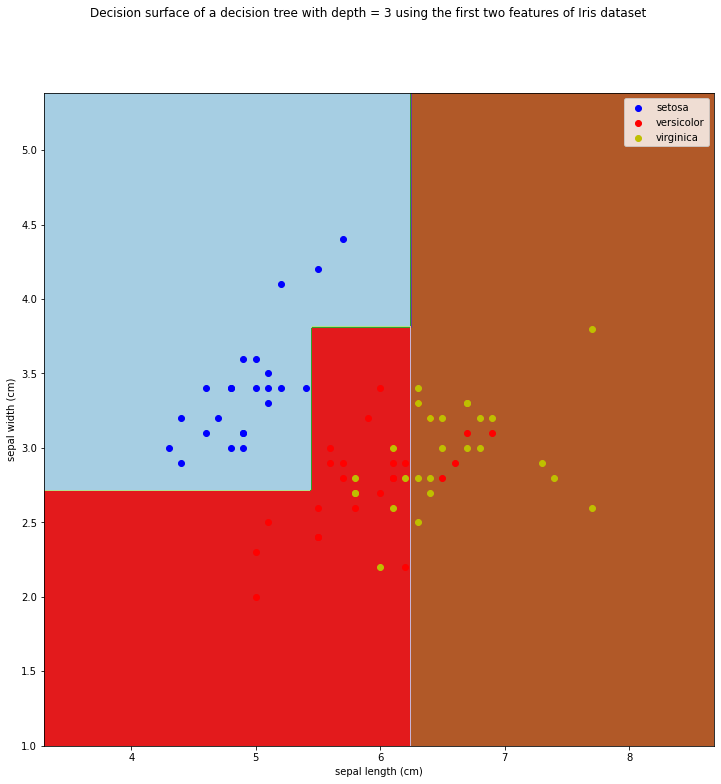

In [226]:
# https://scikit-learn.org/0.15/auto_examples/tree/plot_iris.html
def myDTC_plotter(depth):
    # Parameters
    n_classes = 3
    plot_colors = "bry"
    plot_step = 0.02
    #pairs = enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]])
    pairs = enumerate([[0, 1]])
    for pairidx, pair in pairs:
        # Train
        X = X_train
        y = y_train
        clf = DTCs[depth - 1].fit(X, y)
        #print(type(clf))

        # Plot the decision boundary
        plt.rcParams["figure.figsize"] = (12,12)
        plt.plot()
        #plt.subplot(2, 3, pairidx + 1)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        #print(Z.shape)
        Z = Z.reshape(xx.shape)
        #print(Z.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

        plt.xlabel(iris.feature_names[pair[0]])
        plt.ylabel(iris.feature_names[pair[1]])
        plt.axis("tight")

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                        cmap=plt.cm.Paired)

        plt.axis("tight")

    plt.suptitle(f"Decision surface of a decision tree with depth = {depth} using the first two features of Iris dataset")
    plt.legend()
    plt.show()

myDTC_plotter(topDepth)


# Μέρος B
Στην κλάση myRandomForestClassifier υλοποιείται ταξινομητής Random Forest  100 δέντρων απόφασης με την μέθοδο Boostrap. Κάθε δέντρο απόφασης εκπαιδεύεται βάσει ενός επεξεργασμένυ dataset του μέρους Α. Συγκεκριμένα, το νέο dataset έχει γ = 50% του αρχικού train set και αυτό το νέο ποσοστό δειγμάτων επαναδειγματοληπτείται με Boostrap.

In [230]:
# Sampling with bootstrap method
def bootstrap(X, y, gamma = 0.5):
    samples = np.floor(gamma * X.shape[0])
    samples = samples.astype(int)
    randomPickerIdx = np.random.choice(samples, samples, replace=True)
    return X[randomPickerIdx], y[randomPickerIdx]

# https://docs.python.org/3/library/collections.html#collections.Counter.most_common
# Most common target label found of 3 iris spieces
def mostCommonTarget(y):
    y_counter = Counter(y)
    return y_counter.most_common(1)[0][0]


class myRandomForestClassifier:

    def __init__(self, numberOfTrees = 100, gamma = 1, min_samples_split = 2, max_depth = 100):
        self.numberOfTrees = numberOfTrees
        self.forest = []
        self.gamma = gamma
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def fit(self, X, y):
        for _ in range(self.numberOfTrees):
            tree = DecisionTreeClassifier(min_samples_split = self.min_samples_split, max_depth = self.max_depth)
            X_Bsamples, y_Bsamples = bootstrap(X, y, self.gamma)
            tree.fit(X_Bsamples, y_Bsamples)
            self.forest.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.forest])
        # column wise sets => vertical stacking
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [mostCommonTarget(tree_pred) for tree_pred in tree_preds]
        y_pred = np.array(y_pred)
        return y_pred

$\textbf{B.1}$ Ταξινόμηση δειγμάτων σύμφωνα με τον ταξινομητή myRandomForestClassifier για δοκιμές με διαφορετικά βάθη. Τα βάθη των δοκιμών ήταν σε ένα εύλογο εύρος βαθών. Ύστερα από την επαναληπτική δοκιμή προκύπτει ως καλύτερο βάθος αυτό που μας δίνει το καλύτερο ποσοστό ακρίβειας. 

In [231]:
gamma = 0.5

acc_scores_RF = np.zeros((depth + 1,1))
RFC_predicts = []
for i in range(1, depth + 1):
    RFC = myRandomForestClassifier(numberOfTrees = 100, gamma = gamma, max_depth = i)
    RFC.fit(X_train, y_train)
    prediction = RFC.predict(X_test)
    RFC_predicts.append(prediction)
    acc_scores_RF[i] = accuracy_score(y_true = y_test, y_pred = prediction)

acc_scores_RF = np.round(acc_scores_RF * 100, 3)
print(f"All the accuracy scores are: {acc_scores_RF[:,0]}")
topAccScoreIdx = np.argmax(acc_scores_RF)
topAccScoreVal = acc_scores_RF[topAccScoreIdx, 0]
topDepth = depths[topAccScoreIdx, 0]
print(f"Most efficient depth of tree is {topDepth} by achieving accuracy score percentage of {topAccScoreVal}")

All the accuracy scores are: [ 0.    62.667 78.667 77.333 72.    72.    72.    70.667 70.667 72.   ]
Most efficient depth of tree is 2 by achieving accuracy score percentage of 78.667


$\textbf{Β.2}$ Απεικόνηση  των ορίων απόφασης του ταξινομητή Random Forest με το καλύτερο βάθος που βρέθηκε παραπάνω

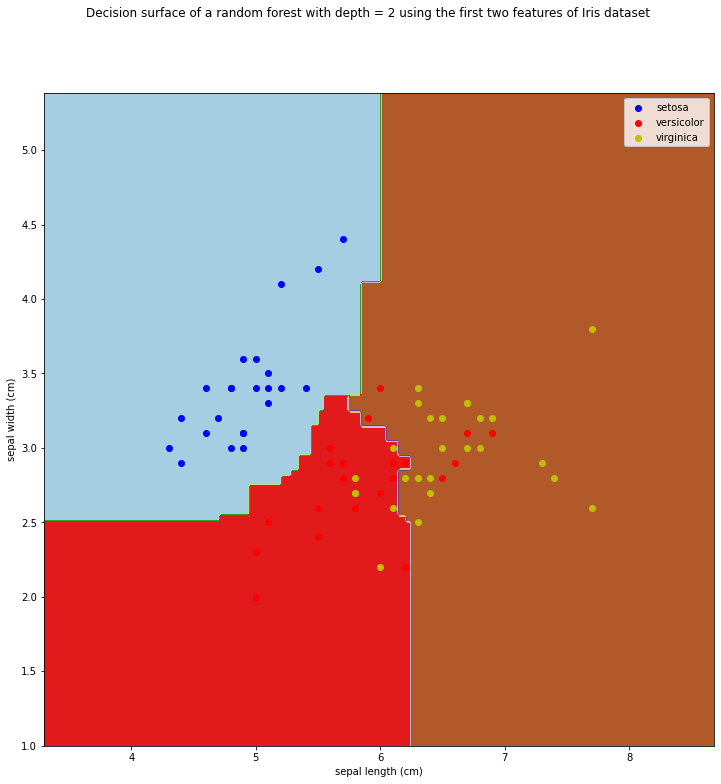

In [233]:
def myRFC_plotter(depth):
    y_pred = RFC_predicts[depth]
    # Parameters
    n_classes = 3
    plot_colors = "bry"
    plot_step = 0.02
    #pairs = enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]])
    pairs = enumerate([[0, 1]])
    for pairidx, pair in pairs:
        # Train
        X = X_train
        y = y_train
        clf = RandomForestClassifier(n_estimators = 100, max_depth = depth, max_features = gamma, bootstrap = True).fit(X, y)

        # Plot the decision boundary
        plt.rcParams["figure.figsize"] = (12,12)
        plt.plot()
        #plt.subplot(2, 3, pairidx + 1)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        #print(Z.shape)
        Z = Z.reshape(xx.shape)
        #print(Z.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

        plt.xlabel(iris.feature_names[pair[0]])
        plt.ylabel(iris.feature_names[pair[1]])
        plt.axis("tight")

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                        cmap=plt.cm.Paired)

        plt.axis("tight")

    plt.suptitle(f"Decision surface of a random forest with depth = {depth} using the first two features of Iris dataset")
    plt.legend()
    plt.show()

myRFC_plotter(topDepth)

## Σύγκριση των 2 μεθόδων ταξινόμησης βάσει των αποτελεσμάτων και από τα 2 μέρη
Παρατηρούμε ότι ο ταξινομητής Random Forest είναι πιο πετυχημένος από έναν απλό Decision Tree ταξινομητή. Αυτό οφείλεται στο οτι ένας ταξινομητής Random Forest εις βάρος της υπολογιστικής πολυπλοκότητας αποτελείται από πολλά δέντρα απόφασης για μια καλύτερη ακρίβεια πρόβλεψης. 

$\textbf{Β.3}$ Μελέτη της επιρροής του συντελεστή $\gamma$ στην ποιότητα και την απόδοση του αλγορίθμου με κάποιο παράδειγμα. Επιλέχτηκε ως παράδειγμα να δοκιμαστεί ο ταξινομητής Random Forest με:
- συγκεκριμένο βάθος, το οποίο επιλέχθηκε να είναι το καλύτερο βάθος που υπολογίστηκε στα παραπάνω ερωτήματα
- συντελεστή $\gamma$ σε ένας εύρος από 10% μέχρι 100% με αυξητικό βήμα 10% κατά επανάληψη


In [234]:
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

acc_scores_RF_gamma = np.zeros((len(gammas),1))
for i in range(0, len(gammas)):
    clf = myRandomForestClassifier(numberOfTrees = 100, gamma = gammas[i], max_depth = topDepth)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc_scores_RF_gamma[i] = accuracy_score(y_true=y_test, y_pred=prediction)

acc_scores_RF_gamma = np.round(acc_scores_RF_gamma * 100, 3)
print(f"All the accuracy scores are: {acc_scores_RF_gamma[:,0]}")
topAccScoreIdx = np.argmax(acc_scores_RF_gamma)
topAccScoreVal = acc_scores_RF_gamma[topAccScoreIdx, 0]
topG = gammas[topAccScoreIdx]
print(f"Most efficient gamma parameter equals to {topG} by achieving accuracy score percentage of {topAccScoreVal}")


All the accuracy scores are: [58.667 69.333 68.    76.    78.667 73.333 77.333 76.    74.667 74.667]
Most efficient gamma parameter equals to 0.5 by achieving accuracy score percentage of 78.667


## Σχολιασμός επιρροής συντελεστή $\gamma$
Παρατηρούμε ότι ο συντελεστής $\gamma$ όταν είναι χαμηλός τότε έχουμε μεγαλύτερη πιθανότητα να είναι χαμηλό το ποσοστό ακριβείας, ενώ σε μεγαλύτερες τάξεις τιμών $\gamma$ καταλήγουμε σε παρόμοιο και σχετικά καλό ποσοστό ακριβείας. Αυτό οφείλεται στο οτι το νέο dataset για train έχει ανάγκη ένα ικανοποιητικό ποσοστό δειγμάτων από το dataset του μέρους Α προκειμένου να υπάρχει στην συνέχεια του Random Forest ταξινομητή επαρκή ποικιλία δειγμάτων προς επαναδειγματοληψία κατά Bootstrap για κάθε δέντρο του από τα 100. 